In [106]:
!pip install torch
!pip install matplotlib
!pip install torchvision
!pip install cv
!pip install opencv-python

In [107]:
import cv2
import os
import glob
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision 
import torchvision.transforms as T 
from PIL import Image
import random
import cv
#img_dir = "C:/Users/Adam/Downloads/UF_Spring_2022/Deep_Learning/Proj2/face_images/"
#img_dir = "/Users/sahajpatel/Downloads/face_images/"
img_dir = "Deep Learning Data/face_images"
torch.set_default_tensor_type('torch.FloatTensor')

if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
device = torch.device(dev)

print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
  

Is CUDA supported by this system? False
CUDA version: None


In [108]:
def load_images_from_folder(folder, num):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)
            #ret = cv2.imwrite('Faces/Augmented/%05d.jpg' % (num), img)
            num += 1
    return images

In [109]:
k = 0
data = load_images_from_folder(img_dir, k)

In [110]:
data = np.asarray(data)
print(data.shape)

(750, 128, 128, 3)


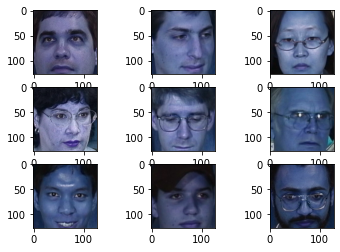

In [111]:
for i in range(0,9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(data[i][:,:,:])

Now we will convert how the images are stored and augment them to get more data 

In [112]:
data = torch.from_numpy(data) #converts numpy matrix to tensor
data = torch.movedim(data, 3, 1) #moves the rgb to the second index
data = data[torch.randperm(data.size()[0])]#randomly shuffles tensor along first dim 

In [113]:
#helper function to print pytorch tensor 
#input is a single tensor
def print_tensor_to_numpy(tensor):
    tensor_reshape = torch.movedim(tensor, 0, 2)
    npimg = tensor_reshape.numpy()
    plt.imshow(npimg[:, :, :])   

Augment Dataset

In [114]:
#flips the image, takes a single image and shows result if show is set to True
def flip_img(tensor, show =False):
    flipped_img = torch.flip(tensor, (2,))
    if show == True:
        print_tensor_to_numpy(flipped_img)
    return flipped_img

In [115]:
#crops image takes a single image tensor and crops it, shows image if show is set to true
def crop_img(tensor, show = False):
    crop = T.RandomCrop((96,96)) # transform for square crop
    resize_crop = T.Resize((128,128)) #resizes image back to original dimension
    cropped_img = resize_crop(crop(tensor)) 
    if show == True:
        print_tensor_to_numpy(cropped_img)
    return cropped_img

In [116]:
def tint_img(tensor, show = False):
    tint_val = 0.1*random.randrange(6, 10)
    tensor[0, :, :] = tint_val*tensor[0, :, :]
    tensor[1, :, :] = tint_val*tensor[1, :, :]
    tensor[2, :, :] = tint_val*tensor[2, :, :]
    tinted_img = tensor[:, :, :]
    if show == True:
        print_tensor_to_numpy(tinted_img)
    return tinted_img

In [117]:
########################

#its not really specified how the new data should be made for example should we flip all of the images, 750+750
#and then crop the original images 3 times an image to make another 3*750 images
#and then tint the original images 0.6-1 thus producing 4*750
#or if we should just apply some random combination of all of the transforms and use that to create the new images


######################
#weird combination of all the transforms
def create_new_img(tensor, show = False):
    chance = random.randrange(0, 10)
    #60% chance of only one transformation
    if (chance < 2):
        new_img = flip_img(tensor) 
    elif (chance >= 2 and chance <4):
        new_img = crop_img(tensor)
    elif (chance >= 4 and chance <6):
        new_img = tint_img(tensor)
    #40% chance of more complex transformations
    elif (chance >= 6 and chance <8):
        tensor_cropped = crop_img(tensor)
        tensor_tinted = tint_img(tensor_cropped)
        new_img = tensor_tinted
    elif (chance >= 8 and chance <=10):
        tensor_flipped = flip_img(tensor) 
        tensor_cropped = crop_img(tensor_flipped)
        tensor_tinted = tint_img(tensor_cropped)
        new_img = tensor_tinted
        
    if show == True:
        print_tensor_to_numpy(new_img)
        
    return new_img


In [118]:
###for loop which appends the newly created images (takes a while)
k = 750
for j in range(0, 1): #change this 1 to 7
    for i in range(0, 750):
        new_img = create_new_img(data[i, :, :, :])
        new_img = new_img[None, :, :, :] #extending the dimensions so that vector can be appended
        data = torch.cat((data, new_img), 0)
        tmp = new_img.numpy()
        tmp = tmp[0].swapaxes(0,1)
        tmp = tmp.swapaxes(1,2)
        #plt.imshow(tmp)
        #ret = cv2.imwrite('Faces/Augmented/%05d_A.jpg' % (k), tmp)
        k += 1
print("Done augmenting data...")

Done augmenting data...


In [119]:
def convToLab_saveToFile(dataset):
    output = []
    outputl = []
    outputa = []
    outputb = []
    for i in range(len(dataset)):
        image = np.asarray(dataset[i,:,:,:])
        image = np.swapaxes(image,1,0)
        image = np.swapaxes(image,1,2)
        imageLAB = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        window_name='image_LAB'
        l,a,b = cv2.split(imageLAB)
        #statusL = cv2.imwrite('Faces/L/%05d_L.jpg' % (i), l)
        #statusa = cv2.imwrite('Faces/a/%05d_a.jpg' % (i), a)
        #statusb = cv2.imwrite('Faces/b/%05d_b.jpg' % (i), b)
        output.append(imageLAB)
        outputl.append(l)
        outputa.append(a)
        outputb.append(b)
    return np.asarray(output),np.asarray(outputl),np.asarray(outputa),np.asarray(outputb)
imageLab, l, a, b = convToLab_saveToFile(data)
imageLab = np.swapaxes(imageLab,2,3)
imageLab = np.swapaxes(imageLab,1,2)
print("Done converting")

Done converting


So basically, the premise here is to input the L* values from the conversion into the regressor and it would predict the a* and b* average chrominance values, im assuming by comparing with the known values of the 2. I tried to set up the convolutional layers but I can't tell if it is working as expected. We need to feed this into a fully connected network to do the rest of the leg work, iirc. This may help us: https://www.kaggle.com/basu369victor/image-colorization-basic-implementation-with-cnn

In [120]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 3, kernel_size=3, stride = 2, padding = 1)
        #self.c1bn = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(in_channels = 3, out_channels = 3, kernel_size=3, stride = 2, padding = 1)
        #self.c2bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels = 3, out_channels = 3, kernel_size=3, stride = 2, padding = 1)
        #self.c3bn = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(in_channels = 3, out_channels = 3, kernel_size=3, stride = 2, padding = 1)
        #self.c4bn = nn.BatchNorm2d(16)
        self.conv5 = nn.Conv2d(in_channels = 3, out_channels = 3, kernel_size=3, stride = 2, padding = 1)
        #self.c5bn = nn.BatchNorm2d(8)
        self.conv6 = nn.Conv2d(in_channels = 3, out_channels = 3, kernel_size=3, stride = 2, padding = 1)
        #self.c6bn = nn.BatchNorm2d(4)
        self.conv7 = nn.Conv2d(in_channels = 3, out_channels = 2, kernel_size=3, stride = 2, padding = 1)
        #self.c7bn = nn.BatchNorm2d(2)

    def forward(self, x):
        x = self.conv1(x)
        #x = F.relu(self.c1bn(x))
        x = F.relu(x)
        x = self.conv2(x)
        #x = F.relu(self.c2bn(x))
        x = F.relu(x)
        x = self.conv3(x)
        #x = F.relu(self.c3bn(x))
        x = F.relu(x)
        x = self.conv4(x)
        #x = F.relu(self.c4bn(x))
        x = F.relu(x)
        x = self.conv5(x)
        #x = F.relu(self.c5bn(x))
        x = F.relu(x)
        x = self.conv6(x)
        #x = F.relu(self.c6bn(x))
        x = F.relu(x)
        x = self.conv7(x)
        #x = F.relu(self.c7bn(x))
        x = F.relu(x)
        return x

normData = torch.from_numpy(l).to(torch.float32)
normData = normData.unsqueeze(1)
model = NN().to(device)
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

bs = 32
x_set = l
x_set = x_set[:,np.newaxis,:,:]

x_max = x_set.max(axis=(0,1,2,3), keepdims=True)
x_min = x_set.min(axis=(0,1,2,3), keepdims=True)

x_set = x_set/255
y_set = np.asarray([a,b])
y_set = y_set.swapaxes(0,1)
y_set = np.expand_dims(np.expand_dims(y_set.mean(axis = 2).mean(axis = 2), axis = 2), axis = 2)
y_max = y_set.max(axis=(0,1,2,3), keepdims=True)
y_min = y_set.min(axis=(0,1,2,3), keepdims=True)
norm_ab = y_set/255
train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(x_set).to(torch.float32), torch.from_numpy(norm_ab).to(torch.float32))
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=bs, 
                                           shuffle=True)

for epoch in range(10):
    model.train() 
    for i, (L_data, ab_data) in enumerate(train_loader):
        L_data = L_data.to(device)
        ab_data = ab_data.to(device)
        optimizer.zero_grad()
        outputs = model(L_data)
        loss = criterion(outputs, ab_data)
        loss.backward()
        optimizer.step()
    print ('Epoch [{}/{}], Loss: {}'.format(epoch+1, 10 ,loss.item()))
    

(1500, 1, 128, 128)
(1500, 2, 1, 1)
Epoch [1/10], Loss: 0.1524427980184555 O:  tensor([[[0.2430]],

        [[0.0000]]], grad_fn=<SelectBackward0>) R:  tensor([[[0.3947]],

        [[0.1508]]])
Epoch [2/10], Loss: 0.09655145555734634 O:  tensor([[[0.4437]],

        [[0.0000]]], grad_fn=<SelectBackward0>) R:  tensor([[[0.6119]],

        [[0.5897]]])
Epoch [3/10], Loss: 0.071907639503479 O:  tensor([[[0.4352]],

        [[0.0000]]], grad_fn=<SelectBackward0>) R:  tensor([[[0.4229]],

        [[0.1952]]])
Epoch [4/10], Loss: 0.09241227060556412 O:  tensor([[[0.4354]],

        [[0.0000]]], grad_fn=<SelectBackward0>) R:  tensor([[[0.3227]],

        [[0.5919]]])
Epoch [5/10], Loss: 0.10524710267782211 O:  tensor([[[0.4614]],

        [[0.0000]]], grad_fn=<SelectBackward0>) R:  tensor([[[0.5051]],

        [[0.4190]]])
Epoch [6/10], Loss: 0.12794792652130127 O:  tensor([[[0.3968]],

        [[0.0000]]], grad_fn=<SelectBackward0>) R:  tensor([[[0.4409]],

        [[0.2966]]])
Epoch [7/10],

In [122]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 128, kernel_size=3, stride = 2, padding = 1)
        self.c1bn = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size=3, stride = 2, padding = 1)
        self.c2bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size=3, stride = 2, padding = 1)
        self.c3bn = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(in_channels = 32, out_channels = 16, kernel_size=3, stride = 2, padding = 1)
        self.c4bn = nn.BatchNorm2d(16)
        self.conv5 = nn.Conv2d(in_channels = 16, out_channels = 8, kernel_size=3, stride = 2, padding = 1)
        self.c5bn = nn.BatchNorm2d(8)
        self.conv6 = nn.Conv2d(in_channels = 8, out_channels = 4, kernel_size=3, stride = 2, padding = 1)
        self.c6bn = nn.BatchNorm2d(4)
        self.conv7 = nn.Conv2d(in_channels = 4, out_channels = 2, kernel_size=3, stride = 2, padding = 1)
        self.c7bn = nn.BatchNorm2d(2)
        self.u1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.u2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.u3 = nn.Upsample(scale_factor=2, mode='nearest')
        self.u4 = nn.Upsample(scale_factor=2, mode='nearest')
        self.u5 = nn.Upsample(scale_factor=2, mode='nearest')
        self.u6 = nn.Upsample(scale_factor=2, mode='nearest')
        self.u7 = nn.Upsample(scale_factor=2, mode='nearest')

        self.conv8 = nn.Conv2d(in_channels=2, out_channels=3, kernel_size=3, stride = 1, padding = 1)
        self.conv9 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride = 1, padding = 1)
        self.conv10 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride = 1, padding = 1)
        self.conv11 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride = 1, padding = 1)
        self.conv12 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride = 1, padding = 1)
        self.conv13 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride = 1, padding = 1)
        self.conv14 = nn.Conv2d(in_channels=3, out_channels=2, kernel_size=3, stride = 1, padding = 1)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.c1bn(x))
        x = self.conv2(x)
        x = F.relu(self.c2bn(x))
        x = self.conv3(x)
        x = F.relu(self.c3bn(x))
        x = self.conv4(x)
        x = F.relu(self.c4bn(x))
        x = self.conv5(x)
        x = F.relu(self.c5bn(x))
        x = self.conv6(x)
        x = F.relu(self.c6bn(x))
        x = self.conv7(x)
        x = F.relu(self.c7bn(x))
        x = self.u1(x)
        x = self.conv8(x)
        x = self.u2(x)
        x = self.conv9(x)
        x = self.u3(x)
        x = self.conv10(x)
        x = self.u4(x)
        x = self.conv11(x)
        x = self.u5(x)
        x = self.conv12(x)
        x = self.u6(x)
        x = self.conv13(x)
        x = self.u7(x)
        x = self.conv14(x)
        return x

normData = torch.from_numpy(l).to(torch.float32)
normData = normData.unsqueeze(1)
model = NN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

bs = 32
x_set = l
x_set = x_set[:,np.newaxis,:,:]

x_max = x_set.max(axis=(0,1,2,3), keepdims=True)
x_min = x_set.min(axis=(0,1,2,3), keepdims=True)
#x_set = (x_set-x_min)/(x_max-x_min)
x_set = x_set/255
y_set = np.asarray([a,b])
y_set = y_set.swapaxes(0,1)
y_max = y_set.max(axis=(0,1,2,3), keepdims=True)
y_min = y_set.min(axis=(0,1,2,3), keepdims=True)
#norm_ab = (y_set-y_min)/(y_max-y_min)
norm_ab = y_set/255
train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(x_set).to(torch.float32), torch.from_numpy(norm_ab).to(torch.float32))
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=bs, 
                                           shuffle=True)

for epoch in range(10):
    model.train() 
    tempO = 0
    for i, (L_data, ab_data) in enumerate(train_loader):
        L_data = L_data.to(device)
        ab_data = ab_data.to(device)
        optimizer.zero_grad()
        outputs = model(L_data)
        loss = criterion(outputs, ab_data)
        loss.backward()
        optimizer.step()
        tempO = outputs[16]
    print ('Epoch [{}/{}], Loss: {}'.format(epoch+1, 10 ,loss.item()))

tmpx = torch.from_numpy(np.expand_dims(x_set[0],axis=0)).to(torch.float32)
model.eval()
#out = np.expand_dims(model(tmpx).detach().numpy()*(y_max-y_min)+y_min, axis = 0)
#tmp = np.concatenate((tmpx.detach().numpy()*(x_max-x_min)+x_min,out[0]),axis = 1)

out = np.expand_dims(model(tmpx).detach().numpy(), axis = 0)
tmp = np.concatenate((tmpx.detach().numpy()*100, out[0]*255-128), axis = 1)

tmpN = np.swapaxes(tmp[0],0,1)
tmpN = np.swapaxes(tmpN,1,2)
tmp2 = np.swapaxes(imageLab[0],0,1)
tmp2 = np.swapaxes(tmp2,1,2)
tmpN = (np.round(tmpN))

im = cv2.cvtColor(tmpN,cv2.COLOR_Lab2BGR)
im2 = cv2.cvtColor(tmp2, cv2.COLOR_Lab2BGR)

cv2.imshow("L",im)
cv2.imshow("A", im2)
cv2.waitKey(0)
    

Epoch [1/10], Loss: 0.003530039917677641
tensor([103.]) tensor([132.6814, 126.4055], grad_fn=<MulBackward0>)
Epoch [2/10], Loss: 0.002591754077002406
tensor([11.]) tensor([131.8528, 132.2696], grad_fn=<MulBackward0>)
Epoch [3/10], Loss: 0.0021979326847940683
tensor([12.]) tensor([136.1891, 135.6876], grad_fn=<MulBackward0>)
Epoch [4/10], Loss: 0.0019404228078201413
tensor([27.]) tensor([136.5414, 135.8268], grad_fn=<MulBackward0>)
Epoch [5/10], Loss: 0.001890483545139432
tensor([27.]) tensor([138.5404, 137.9599], grad_fn=<MulBackward0>)
Epoch [6/10], Loss: 0.0016385993221774697
tensor([9.]) tensor([137.0783, 135.8449], grad_fn=<MulBackward0>)
Epoch [7/10], Loss: 0.0016771249938756227
tensor([17.]) tensor([139.8546, 138.9237], grad_fn=<MulBackward0>)
Epoch [8/10], Loss: 0.0014833863824605942
tensor([14.]) tensor([136.8855, 134.9870], grad_fn=<MulBackward0>)
Epoch [9/10], Loss: 0.001391705358400941
tensor([118.]) tensor([138.9908, 137.9346], grad_fn=<MulBackward0>)
Epoch [10/10], Loss: 0

97